In [1]:
# Whenever you update something to the context (e.g. parameters), run this cell
%reload_kedro

2021-07-12 13:55:20,567 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2021-07-12 13:55:20,616 - root - INFO - ** Kedro project Foehn fire impact
2021-07-12 13:55:20,617 - root - INFO - Defined global variable `context`, `session` and `catalog`
2021-07-12 13:55:20,625 - root - INFO - Registered line magic `run_viz`


In [2]:
# Automatically reloads updates in imported python files
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sci
from utils import *
from plotly import graph_objects as go
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from plotly.subplots import make_subplots
#import kedro.framework.context

plt.rcParams["figure.figsize"] = (16,9)
sns.set(font_scale=1.6)
sns.set_style("whitegrid")

In [4]:
# Fire data
df = catalog.load("fire_data_with_foehn_and_control_variables")

2021-07-12 13:55:24,610 - kedro.io.data_catalog - INFO - Loading data from `fire_data_with_foehn_and_control_variables` (CSVDataSet)...


In [5]:
regions = context.params["regions"]

(0.0, 24.0)

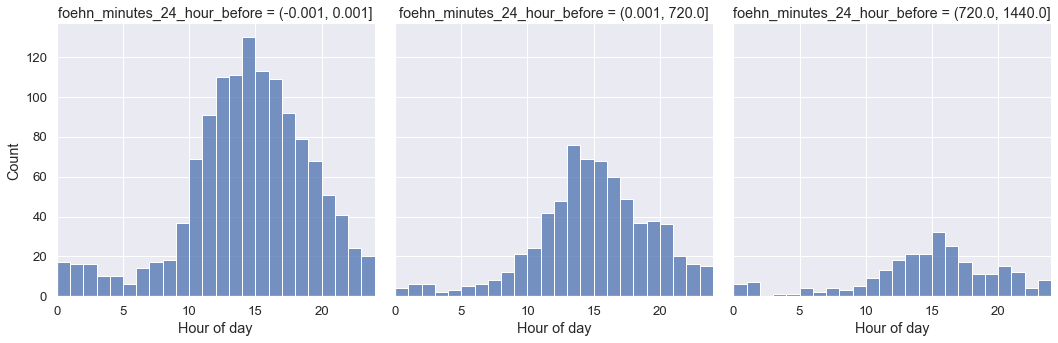

In [6]:
# Investigate hour of day when fire starts, check for shift in distribution for fires with more foehn in beforehand
sns.set(font_scale=1.2)
g = sns.displot(x=df["start_date_min"].dt.hour, 
            col=pd.cut(df["foehn_minutes_24_hour_before"], bins= [-0.001, 0.001, 12*60, 24*60]),
            bins=range(0,24+1),  kind="hist")
for i in range(3):
    g.axes[0,i].set_xlabel("Hour of day")
plt.xlim([0,24])

<AxesSubplot:xlabel='duration_min', ylabel='Count'>

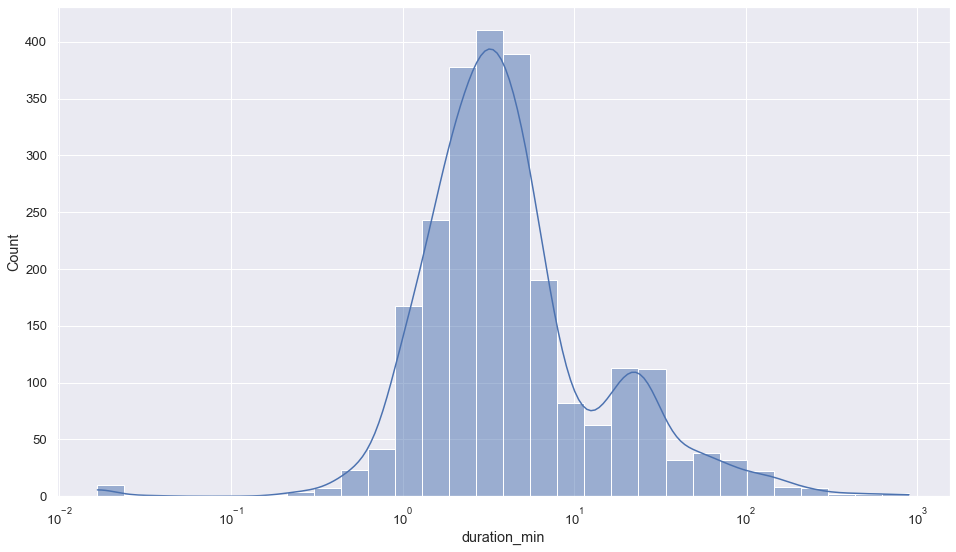

In [8]:
# Fire duration plot
sns.histplot(x=df["duration_min"], log_scale=True, bins=30, stat="count", kde=True)

# Before fire ignition

In [9]:
df_foehn = catalog.load("foehn_data_prepared")

2021-07-12 13:55:43,876 - kedro.io.data_catalog - INFO - Loading data from `foehn_data_prepared` (CSVDataSet)...


In [10]:
df_rain = catalog.load("rain_data")

2021-07-12 13:56:02,688 - kedro.io.data_catalog - INFO - Loading data from `rain_data` (CSVDataSet)...


In [11]:
# Rain data goes from 0700 to 0700 the next day (Swiss time). However, shift by 14 hours here, since this is the peak of fire occurrence
# Thus, rain data refers to 0700-0700 of previous day
day_start_time = 14
df_rain["date"] = df_rain["date"] + pd.Timedelta(hours=day_start_time) + pd.Timedelta(days=1)

# Merge with foehn data
df_merge = pd.merge(df_foehn, df_rain, on ="date", how="left")

In [26]:
# Generate plot depening on target variables, bins, and regions 
@interact
def foehn_before_fire(
    target_var=["Fire_count", "Fire_days"],
    bins=["multiple", "binary"],
    fire_regime=["All fires", "Winter anthropogenic", "Summer anthropogenic"],
    decade=["All", "[1980, 1989]", "[1990, 1999]","[2000, 2009]","[2010, 2019]", ">1990"],
    region=["southern_switzerland", "northern_switzerland"]):
    
    
    # Map bins correctly
    if bins == "multiple":
        bins = [-1, 1, 240, 480, 720, 960, 1200, 1440]
    else:
        bins = [-1, 1, 24 * 60]
        
    # Make copies to not alter original dataframes
    dff = df.copy()
    df_mergef = df_merge.copy()
        
    # Filter by fire regime 
    if fire_regime == "Winter anthropogenic":
        dff = dff.loc[dff["fire_regime"] == "Winter anthropogenic", : ].reset_index(drop=True)
        df_mergef = df_mergef.loc[(df_mergef["date"].dt.month < 5) | (df_mergef["date"].dt.month == 12), :].reset_index(drop=True)
    elif fire_regime == "Summer anthropogenic":
        dff = dff.loc[dff["fire_regime"] == "Summer anthropogenic", : ].reset_index(drop=True)
        df_mergef = df_mergef.loc[(df_mergef["date"].dt.month >= 5) & (df_mergef["date"].dt.month < 12), :].reset_index(drop=True)
           
    # Filter by decade
    if decade == "[1980, 1989]":
        dff = dff.loc[dff["decade"] == "[1980, 1989]", : ].reset_index(drop=True)
        df_mergef = df_mergef.loc[(df_mergef["date"].dt.year >=1980) & (df_mergef["date"].dt.year < 1990), :].reset_index(drop=True)
    if decade == "[1990, 1999]":
        dff = dff.loc[dff["decade"] == "[1990, 1999]", : ].reset_index(drop=True)
        df_mergef = df_mergef.loc[(df_mergef["date"].dt.year >=1990) & (df_mergef["date"].dt.year < 2000), :].reset_index(drop=True)
    if decade == "[2000, 2009]":
        dff = dff.loc[dff["decade"] == "[2000, 2009]", : ].reset_index(drop=True)
        df_mergef = df_mergef.loc[(df_mergef["date"].dt.year >=2000) & (df_mergef["date"].dt.year < 2010), :].reset_index(drop=True)
    if decade == "[2010, 2019]":
        dff = dff.loc[dff["decade"] == "[2010, 2019]", : ].reset_index(drop=True)
        df_mergef = df_mergef.loc[(df_mergef["date"].dt.year >=2010) & (df_mergef["date"].dt.year < 2020), :].reset_index(drop=True)
    if decade == ">1990":
        dff = dff.loc[dff["start_date_min"].dt.year > 1990, : ].reset_index(drop=True)
        df_mergef = df_mergef.loc[(df_mergef["date"].dt.year >1990), :].reset_index(drop=True)
    
    # Depending on the target variable, a different function will be called
    if target_var =="Fire_count":
        plot_fire_count_over_foehn_days(dff, df_foehn=df_mergef, bins=bins, stations=regions[region], day_start_time=day_start_time)
    else:
        plot_fire_day_count_over_foehn_days(dff, df_foehn=df_mergef, bins=bins, stations=regions[region], day_start_time=day_start_time)

interactive(children=(Dropdown(description='target_var', options=('Fire_count', 'Fire_days'), value='Fire_coun…

# After fire ignition

In [27]:
def filter_data(df, hours, fire_regime, decade, foehn_variant):
    # Filter out all values where foehn presence is unknown
    df = df.loc[df[f"foehn_minutes_during_{hours}_hours_after_start_of_fire"].notnull(), :].reset_index(drop=True)
    
    # Filter by fire regime
    if fire_regime != "All fires":
        df = df.loc[df["fire_regime"]==fire_regime, :].reset_index(drop=True)
    
    # Filter by decade
    if decade == "All":
        pass
    elif decade == ">1990":
        df = df.loc[df["start_date_min"].dt.year > 1990, :].reset_index(drop=True)
    else:
        df = df.loc[df["decade"] == decade, :].reset_index(drop=True)
    
    # Filter by foehn variant 
    if foehn_variant != "Both":
         df = df.loc[df["foehn_variant"]==foehn_variant, :].reset_index(drop=True)
    
    return df

In [29]:
@interact
def filter_box_plot(
    comparison=["multiple", "binary"],
    hours=[6,2,12],
    fire_regime=["All fires", "Winter anthropogenic", "Summer anthropogenic"],
    decade=["All", "[1980, 1989]", "[1990, 1999]","[2000, 2009]","[2010, 2019]", ">1990"],
    foehn_variant=["Both", "North foehn", "South foehn"]):
    
    # Filter data
    dff = filter_data(df, hours, fire_regime, decade, foehn_variant)
    
    # Set plot type
    if comparison == "multiple":
        dff["foehn_minutes_binned"] = pd.cut(dff[f"foehn_minutes_during_{hours}_hours_after_start_of_fire"], bins = [-0.001, 0.001] + [hours * 10 * i for i in range(1, 6 + 1)])
        figure_title = f"Burned area vs. foehn minutes after ignition<br>N_fires={len(dff.index)}"
    else:
        dff["foehn_minutes_binned"] = pd.cut(dff[f"foehn_minutes_during_{hours}_hours_after_start_of_fire"], bins = [-0.001, 0.001, 60 * hours])
        pvalue, median_increase_factor = test_binary_bins(dff, hours=hours)
        figure_title = f"Burned area vs. foehn minutes after ignition<br>N_fires={len(dff.index)}<br>p-value (Wilcoxon test): {pvalue}<br>Median increase factor: {median_increase_factor}" 
        
    fig = go.Figure()
    fig.add_trace(
        go.Box(x=dff["foehn_minutes_binned"].astype(str),
               y=dff["total [ha]"],
               visible=True)
    )
    fig.update_layout(yaxis_range=(-2.2,2.9), yaxis_type="log", height=900*0.8, width= 1600*0.8, 
                      title=figure_title,
                      title_font_size=11,
                      xaxis_title="Foehn minutes", yaxis_title="Burned area [ha]")
    fig.update_xaxes(categoryorder='array', categoryarray= dff["foehn_minutes_binned"].unique().categories.astype(str))

    
    for i, interval in enumerate(dff["foehn_minutes_binned"].unique().categories):
        fig.add_annotation(x=i, y=-2,
            text=f"N={(dff['foehn_minutes_binned']==interval).sum()}",
            showarrow=False,
            yshift=-10)
    
    fig.show()

interactive(children=(Dropdown(description='comparison', options=('multiple', 'binary'), value='multiple'), Dr…

In [15]:
# Test for significant difference between North and South Foehn
var = "foehn_variant"
for hours in [6,12]:
    test_foehn_within_variable(df, hours=hours, control_var=var, categories = df[var].unique().tolist())

(6h)  North foehn  vs.  South foehn 	 0.448487 	 1.0
(12h)  North foehn  vs.  South foehn 	 0.554766 	 1.0


In [16]:
# Test for significant difference in foehn between decades
var = "decade"
for hours in [6,12]:
    test_foehn_within_variable(df, hours=hours, control_var=var, categories = df[var].unique().tolist()[1:])

(6h)  [1990, 1999]  vs.  [2000, 2009] 	 0.102865 	 2.105
(6h)  [1990, 1999]  vs.  [2010, 2019] 	 0.56312 	 1.429
(6h)  [2000, 2009]  vs.  [2010, 2019] 	 0.245279 	 0.679
(12h)  [1990, 1999]  vs.  [2000, 2009] 	 0.232043 	 2.0
(12h)  [1990, 1999]  vs.  [2010, 2019] 	 0.866525 	 1.538
(12h)  [2000, 2009]  vs.  [2010, 2019] 	 0.278381 	 0.769


## Wind strength influence

In [36]:
@interact
def filter_box_plot_windgusts(
    hours=[6,2,12],
    FFX_quantile=["q75", "q90"],
    fire_regime=["All fires", "Winter anthropogenic", "Summer anthropogenic"],
    decade=["All", "[1980, 1989]", "[1990, 1999]","[2000, 2009]","[2010, 2019]", ">1990"],
    foehn_variant=["Both", "North foehn", "South foehn"]):
    
    # Filter data
    dff = filter_data(df, hours, fire_regime, decade, foehn_variant)

    # Set which column to investigate
    strength_col = f"FFX_{FFX_quantile}_during_{hours}_hours_after_start_of_fire"
    
    # Make figure with two subplots (1 row, 2 columns)
    fig = make_subplots(rows=1, cols=2)
    
    ## HISTOGRAM (Make on left side of the plot)
    bins = {"start":0, "end": 120, "size": 5}
    
    # Add foehn fires
    fig.add_trace(
        go.Histogram(x = dff.loc[dff[f'foehn_minutes_during_{hours}_hours_after_start_of_fire'] > 0, strength_col], name="Foehn fires", xbins=bins, opacity=0.75),
        col=1, row=1 
    )
    
    # Add non-foehn fires
    fig.add_trace(
        go.Histogram(x = dff.loc[dff[f'foehn_minutes_during_{hours}_hours_after_start_of_fire'] == 0, strength_col], name="Non-foehn fires", xbins=bins, opacity=0.75),
        col=1, row=1 
    )
    
    # Set layout properties for plot
    fig.update_layout(barmode='overlay', height=600, hovermode="x",
                      xaxis_title_text=f"FFX {FFX_quantile} [km/h]", yaxis_title_text='Count of fires')
    
    # Add amount of fires in each category to plot (as annotation)
    foehn_fire_amount =  (dff[f'foehn_minutes_during_{hours}_hours_after_start_of_fire'] > 0).sum()
    no_foehn_fire_amount =  (dff[f'foehn_minutes_during_{hours}_hours_after_start_of_fire'] == 0).sum()
    fig.add_annotation(text=f"Amount of foehn-influenced fires: {foehn_fire_amount}<br>Amount of non-foehn-influenced fires: {no_foehn_fire_amount}",
                  xref="x domain", yref="y domain", align="left",
                  x=0.9, y=1, showarrow=False, col=1, row=1)

    ## BOXPLOT: Make right side of plot
    
    # Reduce dataframe only to foehn fires
    dff = dff.loc[dff[f'foehn_minutes_during_{hours}_hours_after_start_of_fire']>0, :].reset_index(drop=True)
    
    # Define bin boundaries (terziles) at sort FFX into these bins
    bins = [dff[strength_col].min(), dff[strength_col].quantile(1/3), dff[strength_col].quantile(2/3), dff[strength_col].max()]
    bins = [round(bin_,1) for bin_ in bins]
    dff["FFX_binned"] = pd.cut(dff[strength_col], bins=bins)
    
    # Make boxplot
    fig.add_trace(
        go.Box(x=dff["FFX_binned"].astype(str), y=dff["total [ha]"], name="Foehn fires", showlegend=False, marker_color="blue", opacity=0.75),
        col=2, row=1, 
    )
    
    # Format boxplot
    fig.update_yaxes(title_text="Burned area [ha]", row=1, col=2, range=(-2.2,2.9), type="log")
    fig.update_xaxes(title_text="FFX q75 [km/h]", categoryorder='array', categoryarray= dff["FFX_binned"].unique().categories.astype(str), row=1, col=2)
    
    # Add amount of fires in each category
    for i, interval in enumerate(dff["FFX_binned"].unique().categories):
        fig.add_annotation(x=i, y=-2, row=1, col=2,
            text=f"N={(dff['FFX_binned']==interval).sum()}",
            showarrow=False,
            yshift=-10)
    
   
    ## WILCOXON TEST: Make annotation with results of a Wilcoxon ranksum test
    # Loop over all possible combinations of FFX bins
    intervals = dff['FFX_binned'].unique().categories.to_list()
    if np.NaN in intervals:
        intervals.remove(np.NaN)
    intervals_dummies = intervals.copy()
    line=0
    for interval in intervals:
        intervals_dummies.remove(interval)
        burned_values_1 = dff.loc[dff["FFX_binned"] == interval, "total [ha]"]
        for interval_dummy in intervals_dummies:
            burned_values_2 = dff.loc[dff["FFX_binned"] == interval_dummy, "total [ha]"]

            fig.add_annotation(text=f"{interval} vs. {interval_dummy}<br>p-value: {round(ranksums(burned_values_1, burned_values_2).pvalue, 6)}<br>Median increase f.: {round(burned_values_2.median() / burned_values_1.median(), 3)}",
                              xref="paper", yref="paper", align="right", font_size=10,
                              x=1.13, y=0.7-line, showarrow=False)
            line+=0.3
    fig.show()

interactive(children=(Dropdown(description='hours', options=(6, 2, 12), value=6), Dropdown(description='FFX_qu…

### Compare to non-foehn

In [35]:
@interact
def filter_box_plot_windgusts(
    hours=[6,2,12],
    FFX_quantile=["q75", "q90"],
    fire_regime=["All fires", "Winter anthropogenic", "Summer anthropogenic"],
    decade=["All", "[1980, 1989]", "[1990, 1999]","[2000, 2009]","[2010, 2019]", ">1990"],
    foehn_variant=["Both", "North foehn", "South foehn"]):
    
    # Filter data
    dff = filter_data(df, hours, fire_regime, decade, foehn_variant)

    # Set which column to investigate
    strength_col = f"FFX_{FFX_quantile}_during_{hours}_hours_after_start_of_fire"
    
    # Make figure with two subplots (1 row, 2 columns)
    fig = make_subplots(rows=1, cols=2, column_widths=[0.4, 0.6])
    
    ## HISTOGRAM (Make on left side of the plot)
    bins = {"start":0, "end": 120, "size": 5}
    
    # Add foehn fires
    fig.add_trace(
        go.Histogram(x = dff.loc[dff[f'foehn_minutes_during_{hours}_hours_after_start_of_fire'] > 0, strength_col], name="Foehn fires", xbins=bins, opacity=0.75),
        col=1, row=1 
    )
    
    # Add non-foehn fires
    fig.add_trace(
        go.Histogram(x = dff.loc[dff[f'foehn_minutes_during_{hours}_hours_after_start_of_fire'] == 0, strength_col], name="Non-foehn fires", xbins=bins, opacity=0.75),
        col=1, row=1 
    )
    
    # Set layout properties for plot
    fig.update_layout(barmode='overlay', height=600, hovermode="x",
                      xaxis_title_text=f"FFX {FFX_quantile} [km/h]", yaxis_title_text='Count of fires')
    
    # Add amount of fires in each category to plot (as annotation)
    foehn_fire_amount =  (dff[f'foehn_minutes_during_{hours}_hours_after_start_of_fire'] > 0).sum()
    no_foehn_fire_amount =  (dff[f'foehn_minutes_during_{hours}_hours_after_start_of_fire'] == 0).sum()
    fig.add_annotation(text=f"Amount of foehn-influenced fires: {foehn_fire_amount}<br>Amount of non-foehn-influenced fires: {no_foehn_fire_amount}",
                  xref="x domain", yref="y domain", align="left",
                  x=0.9, y=1, showarrow=False, col=1, row=1)

    ## BOXPLOT: Make right side of plot
    
    
    
    # Define bin boundaries (terziles) at sort FFX into these bins
    bins = [q for q in np.linspace(0,100,11)]
    bins = [round(bin_,1) for bin_ in bins]
    dff["FFX_binned"] = pd.cut(dff[strength_col], bins=bins)
    
    # Reduce dataframe only to foehn fires
    df_f = dff.loc[dff[f'foehn_minutes_during_{hours}_hours_after_start_of_fire']>0, :].reset_index(drop=True)
    df_nf = dff.loc[dff[f'foehn_minutes_during_{hours}_hours_after_start_of_fire']==0, :].reset_index(drop=True)
    
    # Make boxplot
    fig.add_trace(
        go.Box(x=df_f["FFX_binned"].astype(str), y=df_f["total [ha]"], name="Foehn fires", showlegend=False, marker_color="blue", opacity=0.75),
        col=2, row=1, 
    )
    fig.add_trace(
        go.Box(x=df_nf["FFX_binned"].astype(str), y=df_nf["total [ha]"], name="Foehn fires", showlegend=False, marker_color="red", opacity=0.75),
        col=2, row=1, 
    )
    
    # Format boxplot
    fig.update_layout(boxmode='group')
    fig.update_yaxes(title_text="Burned area [ha]", row=1, col=2, range=(-2.2,2.9), type="log")
    fig.update_xaxes(title_text=f"FFX {FFX_quantile} [km/h]", categoryorder='array', categoryarray= dff["FFX_binned"].unique().categories.astype(str), row=1, col=2)
    
    fig.show()

interactive(children=(Dropdown(description='hours', options=(6, 2, 12), value=6), Dropdown(description='FFX_qu…

# Fire indice interaction

In [19]:
# Load fire indice data
df_indices = catalog.load("fire_indices_data")

2021-07-12 13:57:49,714 - kedro.io.data_catalog - INFO - Loading data from `fire_indices_data` (CSVDataSet)...


In [20]:
# Load fire data again and add a date column
df_fires = catalog.load("fire_data_with_foehn_and_control_variables")
df_fires["date"] = df_fires["start_date_min"].dt.date.astype(np.datetime64)

2021-07-12 13:57:52,120 - kedro.io.data_catalog - INFO - Loading data from `fire_data_with_foehn_and_control_variables` (CSVDataSet)...


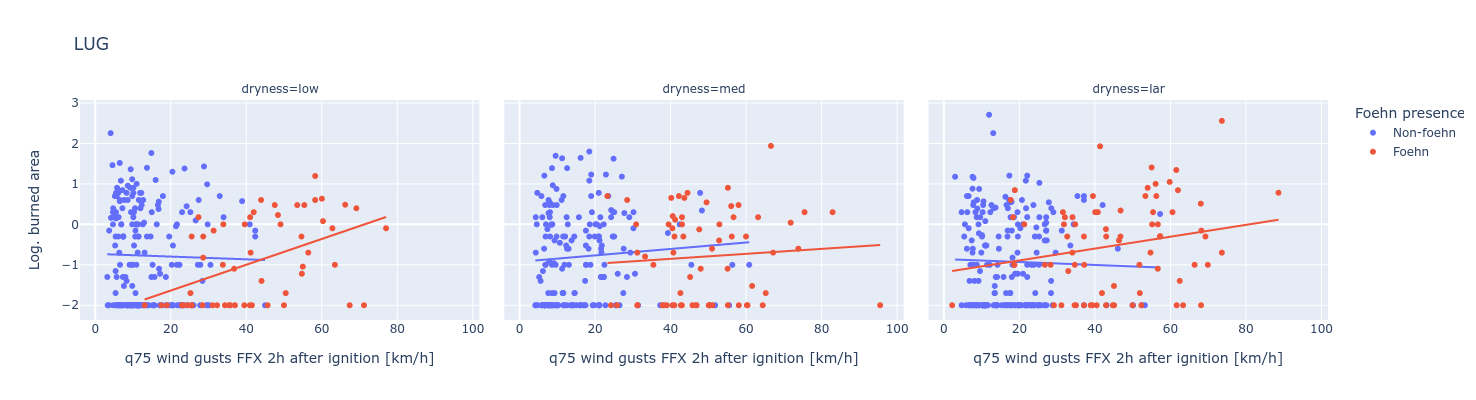

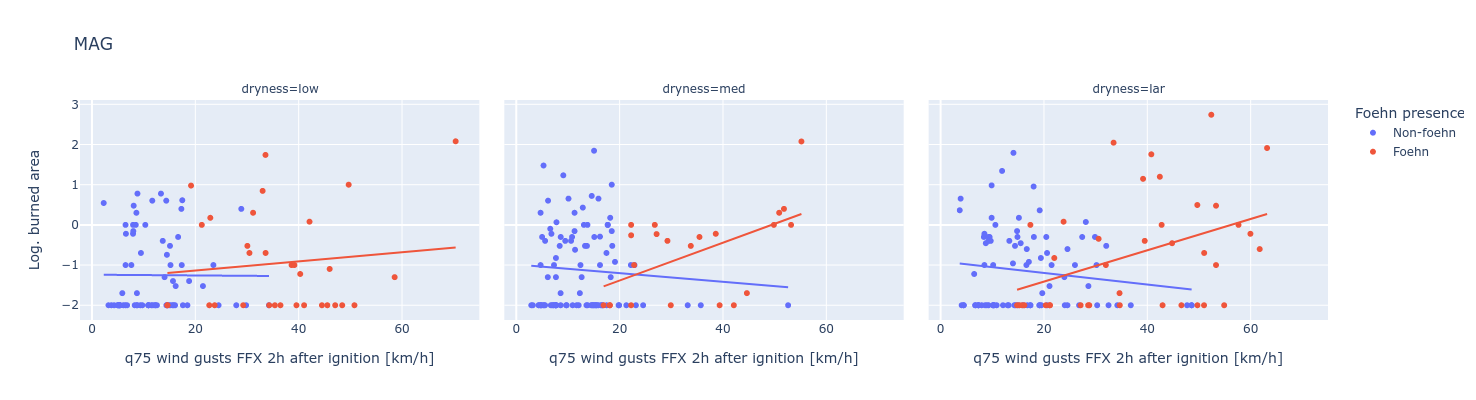

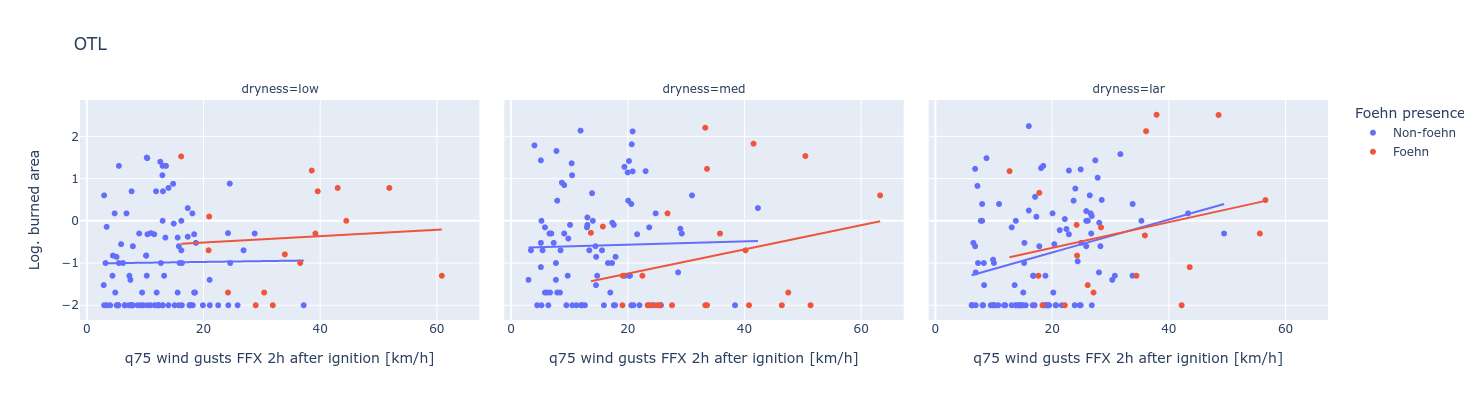

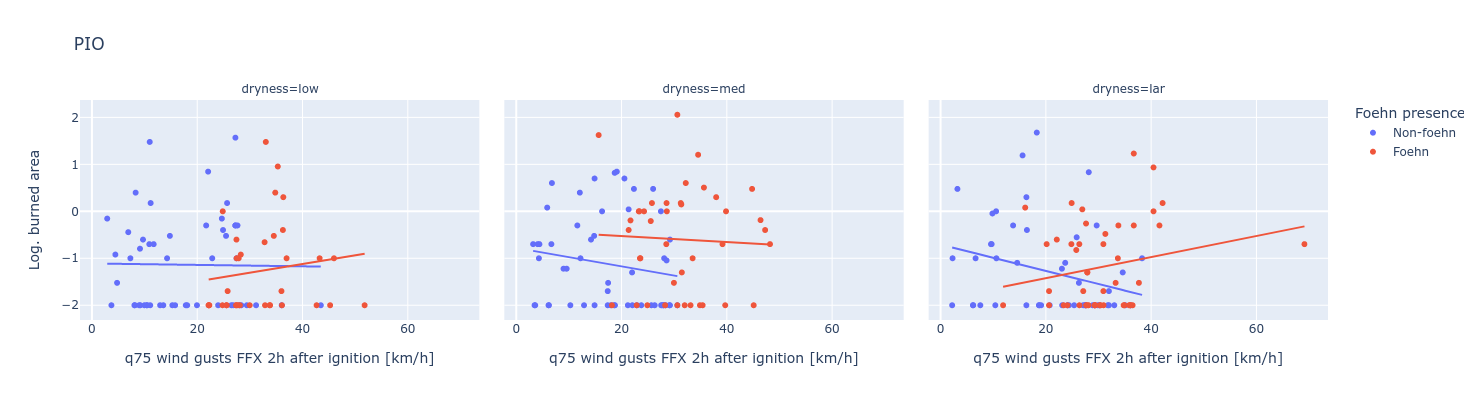

In [22]:
# Loop over all stations
for station in regions["southern_switzerland"] + regions["northern_switzerland"]:
    
    # Filter the indice dataframe for a station
    if station == "MAG": # If station is MAG, use fire indice data from OTL instead (since they are close and no fire indice data is avaliable for MAG)
        df_indices_st = df_indices.loc[df_indices["abbreviation"]=="OTL", :].set_index("date", verify_integrity=True)
    else:
        df_indices_st = df_indices.loc[df_indices["abbreviation"]==station, :].set_index("date", verify_integrity=True)
    
    # Select the indice of interest (here the actual FWI). Shift by one day to look at the ignition conditions the day before.
    df_indices_st["FWI_day_before"] = df_indices_st["FWI"].shift(periods=1, freq="D")
   
    # Filter fires for station of interest.
    df_fires_st = df_fires.loc[df_fires["abbreviation"]==station, :].set_index("date")
    
    # Skip procedure for stations with less than 100 fires in total
    if len(df_fires_st.index) < 100:
        continue
    
    # Join fire data and indice data
    df_st = df_fires_st.join(df_indices_st["FWI_day_before"], how="inner")
    
    # Define ignition conditions/dryness by FWI quantiles of previous day
    df_st["dryness"] = pd.qcut(df_st["FWI_day_before"], q=3, labels=["low", "med", "lar"])
    
    # Set some aliases
    hours = 2
    FFX_q = "q75"
    foehn_variable = f"foehn_minutes_during_{hours}_hours_after_start_of_fire"
    FFX_variable = f"FFX_{FFX_q}_during_{hours}_hours_after_start_of_fire"
    
    # Remove any unknown values
    df_st = df_st.dropna(subset=[foehn_variable, FFX_variable, "FWI_day_before"]).reset_index(drop=True)
    
    # Bin the foehn duration values into non-foehn and foehn
    df_st[f"{foehn_variable}_bin"] = pd.cut(df_st[foehn_variable], bins=[-0.001, 0.001, hours*60], labels=["Non-foehn", "Foehn"])

    # Look at the logarithm of the burned area
    df_st["log_burned_area"] = np.log10(df_st["total [ha]"])
    
    # Plot figure
    fig = px.scatter(
        data_frame=df_st, x=FFX_variable, y="log_burned_area", facet_col="dryness", color=f"{foehn_variable}_bin", title=station,
        category_orders= {"dryness": ["low", "med", "lar"], f"{foehn_variable}_bin": ["Non-foehn", "Foehn"]}, 
        labels={f"{foehn_variable}_bin": "Foehn presence", FFX_variable: f"{FFX_q} wind gusts FFX 2h after ignition [km/h]", "log_burned_area": "Log. burned area"},  
        trendline="ols",
        height=400
    )
    fig.show()

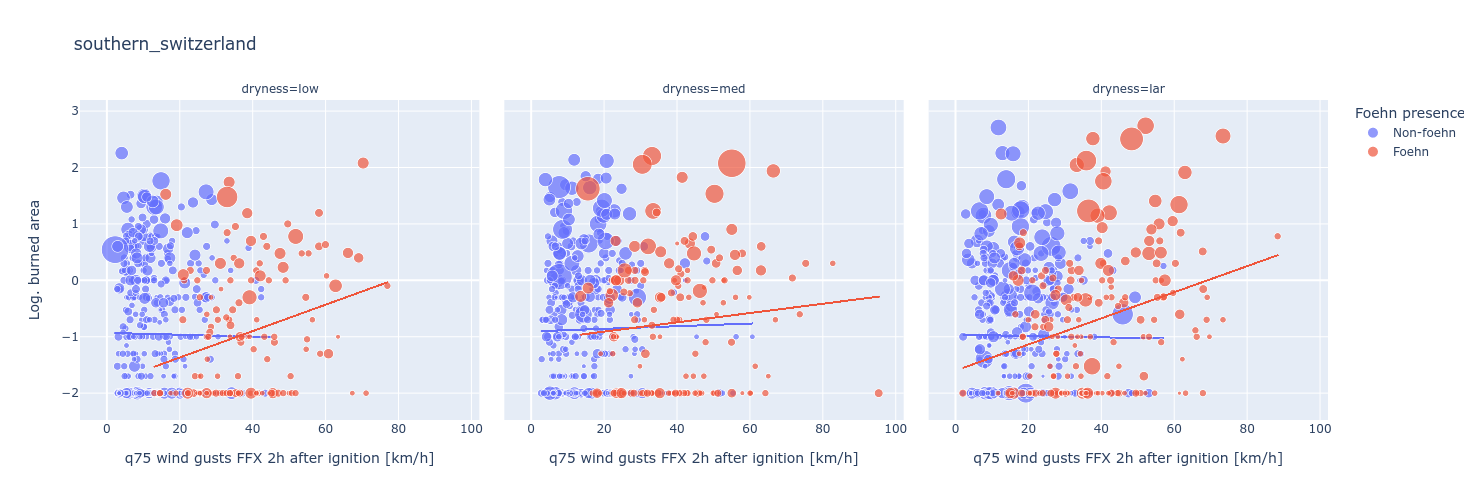

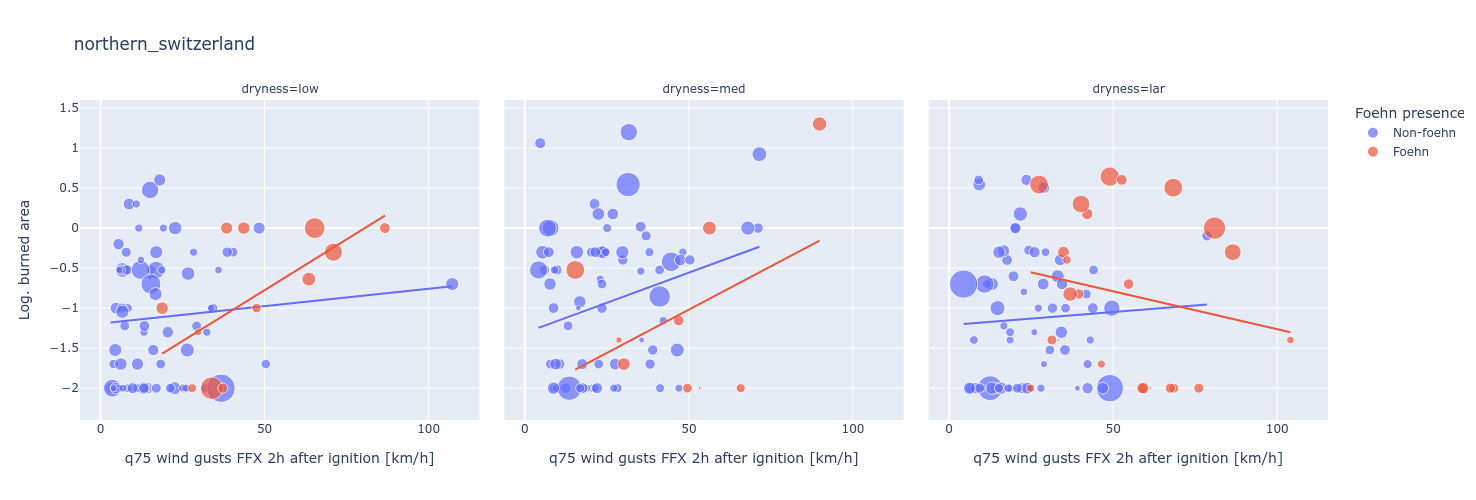

In [23]:
# Loop over all regions
for region in ["southern_switzerland", "northern_switzerland"]:
    df_region = pd.DataFrame()
    for station in regions[region]:

        # Filter the indice dataframe for a station
        if station == "MAG": # If station is MAG, use fire indice data from OTL instead (since they are close and no fire indice data is avaliable for MAG)
            df_indices_st = df_indices.loc[df_indices["abbreviation"]=="OTL", :].set_index("date", verify_integrity=True)
        else:
            df_indices_st = df_indices.loc[df_indices["abbreviation"]==station, :].set_index("date", verify_integrity=True)

        # Select the indice of interest (here the actual FWI). Shift by one day to look at the ignition conditions the day before.
        df_indices_st["FWI_day_before"] = df_indices_st["FWI"].shift(periods=1, freq="D")

        # Filter fires for station of interest.
        df_fires_st = df_fires.loc[df_fires["abbreviation"]==station, :].set_index("date")

        # Join fire data and indice data
        df_st = df_fires_st.join(df_indices_st["FWI_day_before"], how="inner")

        # Define ignition conditions/dryness by FWI quantiles of previous day
        df_st["dryness"] = pd.qcut(df_st["FWI_day_before"], q=3, labels=["low", "med", "lar"])
        
        df_region = pd.concat([df_region, df_st], axis=0, ignore_index=True)
    
    # Set some aliases
    hours = 2
    FFX_q = "q75"
    foehn_variable = f"foehn_minutes_during_{hours}_hours_after_start_of_fire"
    FFX_variable = f"FFX_{FFX_q}_during_{hours}_hours_after_start_of_fire"
    
    # Remove any unknown values
    df_region = df_region.dropna(subset=[foehn_variable, FFX_variable, "FWI_day_before"]).reset_index(drop=True)
    
    # Bin the foehn duration values into non-foehn and foehn
    df_region[f"{foehn_variable}_bin"] = pd.cut(df_region[foehn_variable], bins=[-0.001, 0.001, hours*60], labels=["Non-foehn", "Foehn"])

    # Look at the logarithm of the burned area
    df_region["log_burned_area"] = np.log10(df_region["total [ha]"])
    df_region["sqrt_duration_min"] = np.sqrt(df_region["duration_min"])  # Take square root for visibility
    
    # Plot figure
    fig = px.scatter(
        data_frame=df_region, x=FFX_variable, y="log_burned_area", facet_col="dryness", color=f"{foehn_variable}_bin", title=region, size="sqrt_duration_min",
        category_orders= {"dryness": ["low", "med", "lar"], f"{foehn_variable}_bin": ["Non-foehn", "Foehn"]}, 
        labels={f"{foehn_variable}_bin": "Foehn presence", FFX_variable: f"{FFX_q} wind gusts FFX 2h after ignition [km/h]", "log_burned_area": "Log. burned area", "sqrt_duration_min" : "(Size) Root of fire duration"},  
        trendline="ols",
        height=500
    )
    fig.show()